# Logistic Regression 

#### Notes

p = probability
p/1-p = odds ratio 

logit(p) = ln(p/1-p) = ln(odds)

You take the natural log because regression requires normally distributed residuals -- binary outcomes/odds alone cannot do this. 

A logratihm is the power to which the base must be raised to produce the number being logged. 

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression

/Users/fnkyazn/anaconda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


### Plotting Binary Outcomes

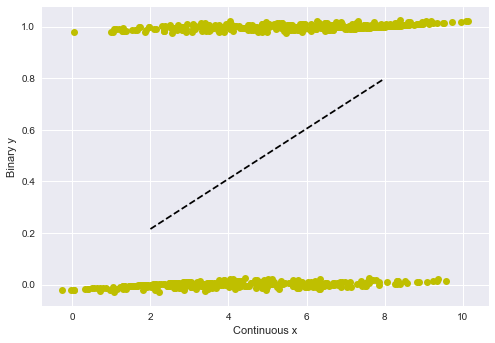

In [3]:
# Set the random seed so that the 'random' data is the same each time
# the code is run.
np.random.seed(seed=456613)

# Create some data.
df = pd.DataFrame()
for probs in list(range(2, 9)):
    tmp = pd.DataFrame({
        'y': np.random.binomial(1, probs / 10, size=(1, 100))[0],
        'x': probs
    }) 
    df = df.append(tmp)

# Continuous predictor.
x = df['x']

# Binary outcome.
bin_y = df['y']

# Calculate linear regression for x and bin_y.
fit = np.polyfit(x,bin_y,1)

# Work as a function to return the predicted value of y.
fit_fn = np.poly1d(fit)

# Add a little 'noise' to the data for graphing purposes.
jitter = np.random.randn(700)

# Display our results.
plt.plot(x + jitter, bin_y + jitter / 100, 'yo', x, fit_fn(x), '--k')
plt.xlabel('Continuous x')
plt.ylabel('Binary y')
plt.show()

### Plotting Odds Ratio

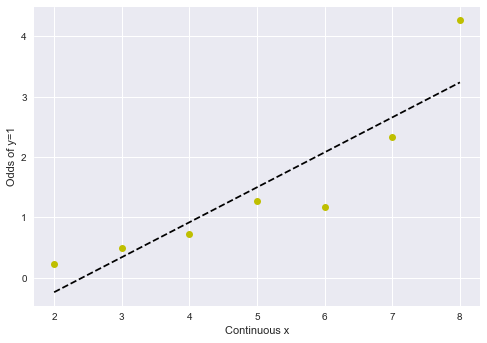

In [4]:
# Unique values in x.
xvals = x.unique()

# Calculate and store the odds.
yodds = []
for xi in xvals: 
    y1_ct = bin_y[x == xi].sum()  # The number of trials y = 1.
    y0_ct = len(bin_y[x == xi]) - y1_ct  # The number of trials y = 0.
    yodds.append(y1_ct / y0_ct)  # Odds of getting y = 1 for xi.
    
# Calculate linear regression for x and yodds.
fit = np.polyfit(xvals, yodds, 1)

# Work as a function to return the predicted value of yodds.
fit_fn = np.poly1d(fit)

# Display our work.
plt.plot(xvals, yodds, 'yo', xvals, fit_fn(xvals), '--k')
plt.xlabel('Continuous x')
plt.ylabel('Odds of y=1')
plt.show()

### Plotting Natural Log of Odds

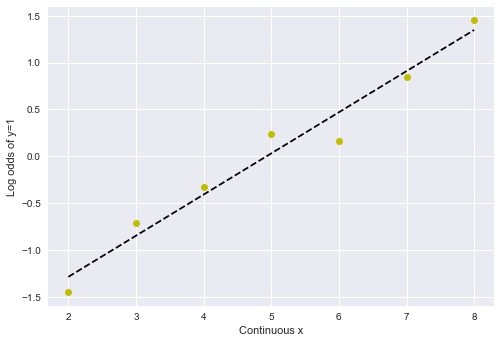

In [5]:
# Natural log of the odds.
ln_yodds = np.log(yodds)

# Calculate linear regression for x and yodds.
fit = np.polyfit(xvals, ln_yodds, 1)

# Works as a function to return the predicted value of yodds.
fit_fn = np.poly1d(fit)

# Display.
plt.plot(xvals, ln_yodds, 'yo', xvals, fit_fn(xvals), '--k')
plt.xlabel('Continuous x')
plt.ylabel('Log odds of y=1')

plt.show()

### Fitting binary logistic model using statsmodels

   admit  gre   gpa  rank
0      0  380  3.61     3
1      1  660  3.67     3
2      1  800  4.00     1
3      1  640  3.19     4
4      0  520  2.93     4


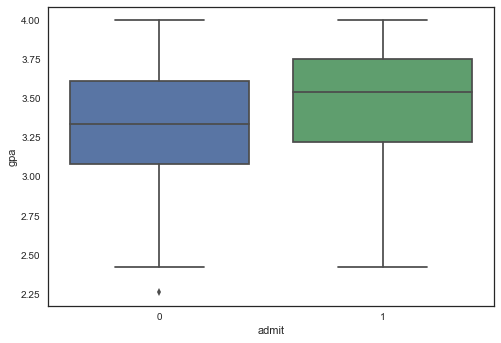

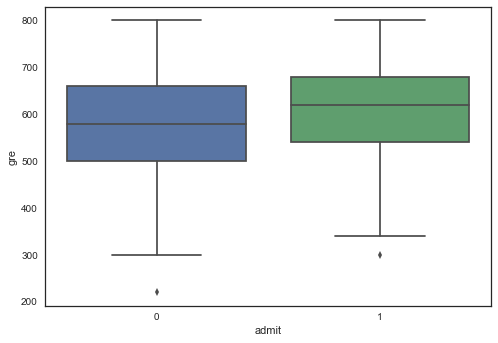

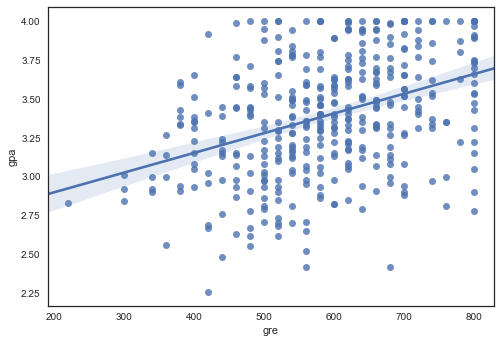

In [6]:
# Read in the data.
df = pd.read_csv("https://www.dropbox.com/s/qhf0ocdqb3gh7ni/logistic_regression.csv?dl=1") 

# Take a peek.
print(df.head())

# Prettier plots are better.
sns.set_style("white")

# Bivariate relationships of predictors to admissions outcome.
sns.boxplot(x="admit", y="gpa", data=df)
plt.show()
sns.boxplot(x="admit", y="gre", data=df)
plt.show()

# Relationship between predictors.
sns.regplot(x='gre', y='gpa', data=df)
plt.show()

In [7]:
# Declare predictors.
X_statsmod = df[['gre', 'gpa']]

# The Statsmodels formulation requires a column with constant value 1 that
# will act as the intercept.
X_statsmod['intercept'] = 1 

# Declare and fit the model.
logit = sm.Logit(df['admit'], X_statsmod)
result = logit.fit()

# Lots of information about the model and its coefficients, but the
# accuracy rate for predictions is missing.
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.600430
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                  admit   No. Observations:                  400
Model:                          Logit   Df Residuals:                      397
Method:                           MLE   Df Model:                            2
Date:                Mon, 25 Dec 2017   Pseudo R-squ.:                 0.03927
Time:                        17:09:25   Log-Likelihood:                -240.17
converged:                       True   LL-Null:                       -249.99
                                        LLR p-value:                 5.456e-05
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
gre            0.0027      0.001      2.544      0.011       0.001       0.005
gpa            0.7547      0.

/Users/fnkyazn/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [8]:
# Calculate accuracy. First, get probability that each row will be admitted.
pred_statsmod = result.predict(X_statsmod)

# Code admission as 1 if probability is greater than .5.
pred_y_statsmod = np.where(pred_statsmod < .5, 0, 1)

# Accuracy table.
table = pd.crosstab(df['admit'], pred_y_statsmod)

print('\n Accuracy by admission status')
print(table)
print('\n Percentage accuracy')
print((table.iloc[0,0] + table.iloc[1,1]) / (table.sum().sum()))


 Accuracy by admission status
col_0    0   1
admit         
0      263  10
1      118   9

 Percentage accuracy
0.68


### Fitting binary logistic model using SKLearn

In [9]:
# Declare a logistic regression classifier.
# Parameter regularization coefficient C described above.
lr = LogisticRegression(C=1e9)
y = df['admit']
X = df[['gpa', 'gre']]

# Fit the model.
fit = lr.fit(X, y)

# Display.
print('Coefficients')
print(fit.coef_)
print(fit.intercept_)
pred_y_sklearn = lr.predict(X)

print('\n Accuracy by admission status')
print(pd.crosstab(pred_y_sklearn, y))

print('\n Percentage accuracy')
print(lr.score(X, y))

Coefficients
[[ 0.74747563  0.00267019]]
[-4.91157158]

 Accuracy by admission status
admit    0    1
row_0          
0      263  118
1       10    9

 Percentage accuracy
0.68


# Ridge Regression


#### Notes

In [11]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import math
import seaborn as sns
import sklearn
from sklearn import linear_model
from sklearn import preprocessing
%matplotlib inline
sns.set_style('white')

### OLS Example

In [12]:
# Load air quality data, drop the index column and any missing data columns.
df = pd.read_csv(
    'https://vincentarelbundock.github.io/Rdatasets/csv/ISLR/Default.csv'
).iloc[:, 1:].dropna()

# Recode strings to numeric.
df['default'] = np.where(df['default'] == 'Yes', 1, 0)
df['student'] = np.where(df['student'] == 'Yes', 1, 0)
names = df.columns
df = pd.DataFrame(preprocessing.scale(df), columns=names)

# Define the training and test sizes.
trainsize = int(df.shape[0] / 2)
df_test = df.iloc[trainsize:, :].copy()
df_train = df.iloc[:trainsize, :].copy()

# Set up the regression model to predict defaults using all other
# variables as features.
regr1 = linear_model.LinearRegression()
Y_train = df_train['income'].values.reshape(-1, 1)
X_train = df_train.loc[:, ~(df_train.columns).isin(['income'])]
regr1.fit(X_train, Y_train)
print('\nR-squared simple model:')
print(regr1.score(X_train, Y_train))

#Store the parameter estimates.
origparams = np.append(regr1.coef_, regr1.intercept_)

# Make new features to capture potential quadratic and cubic relationships
# between the features.
df_train['balance_student'] = df_train['balance'] * df_train['student']
df_train['balance_default'] = df_train['balance'] * df_train['default']
df_train['student_default'] = df_train['student'] * df_train['default']
df_train['balance_sqrt'] = (df_train['balance'] + 100) ** .5
df_train['balance2'] = (df_train['balance'] + 100) ** 2
df_train['balance3'] = (df_train['balance'] + 100) ** 3

# Re-run the model with the new features.
regrBig = linear_model.LinearRegression()
X_train2 = df_train.loc[:, ~(df_train.columns).isin(['income'])]
regrBig.fit(X_train2, Y_train)
print('\nR-squared complex model:')
print(regrBig.score(X_train2, Y_train))

# Store the new parameter estimates for the same features.
newparams = np.append(
    regrBig.coef_[0,0:(len(origparams)-1)],
    regrBig.intercept_)

print('\nParameter Estimates for the same predictors for the small model '
      'and large model:')
compare = np.column_stack((origparams, newparams))
prettycompare = np.array2string(
    compare,
    formatter={'float_kind':'{0:.3f}'.format})
print(prettycompare)


R-squared simple model:
0.573878496272

R-squared complex model:
0.573973445208

Parameter Estimates for the same predictors for the small model and large model:
[[0.014 -0.004]
 [-0.759 -0.759]
 [0.000 4157.866]
 [-0.001 553434.491]]


### Testing simple & complex model on test set

In [13]:
# Test the simpler model with smaller coefficients.
Y_test = df_test['income'].values.reshape(-1, 1)
X_test = df_test.loc[:, ~(df_test.columns).isin(['income'])]
print('\nR-squared simple model:')
print(regr1.score(X_test, Y_test))

# Test the more complex model with larger coefficients.
df_test['balance_student'] = df_test['balance'] * df_test['student']
df_test['balance_default'] = df_test['balance'] * df_test['default']
df_test['student_default'] = df_test['student'] * df_test['default']
df_test['balance_sqrt'] = (df_test['balance'] + 100) ** .5
df_test['balance2'] = (df_test['balance'] + 100) ** 2
df_test['balance3'] = (df_test['balance'] + 100) ** 3

# Re-run the model with the new features.
X_test2 = df_test.loc[:, ~(df_test.columns).isin(['income'])]
print('\nR-squared complex model:')
print(regrBig.score(X_test2, Y_test))


R-squared simple model:
0.56306979225

R-squared complex model:
0.563023952734


### Fitting a ridge regression model

In [14]:
# Fitting a ridge regression model. Alpha is the regularization
# parameter (usually called lambda). As alpha gets larger, parameter
# shrinkage grows more pronounced. Note that by convention, the
# intercept is not regularized. Since we standardized the data
# earlier, the intercept should be equal to zero and can be dropped.

ridgeregr = linear_model.Ridge(alpha=10, fit_intercept=False) 
ridgeregr.fit(X_train, Y_train)
print(ridgeregr.score(X_train, Y_train))
origparams = ridgeregr.coef_[0]
print(origparams)

ridgeregrBig = linear_model.Ridge(alpha=10, fit_intercept=False)
ridgeregrBig.fit(X_train2, Y_train)
print(ridgeregrBig.score(X_train2, Y_train))
newparams = ridgeregrBig.coef_[0, 0:len(origparams)]

print('\nParameter Estimates for the same predictors for the small model'
      'and large model:')
compare = np.column_stack((origparams, newparams))
prettycompare = np.array2string(
    compare,
    formatter={'float_kind':'{0:.3f}'.format})
print(prettycompare)

0.57387391644
[  1.36988466e-02  -7.57859433e-01  -3.25298557e-04]
0.573946428961

Parameter Estimates for the same predictors for the small modeland large model:
[[0.014 -0.002]
 [-0.758 -0.757]
 [-0.000 0.048]]


In [16]:
# BOTH MODELS PERFORM SIMILARLY
print(ridgeregr.score(X_test, Y_test))
print(ridgeregrBig.score(X_test2, Y_test))

0.563108876308
0.563180432393


### Assessing how model changes with regularization parameter lambda

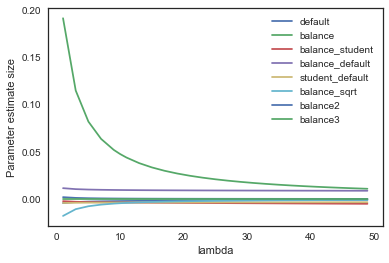

In [17]:
# Store estimates.
estimates = np.append(ridgeregrBig.coef_, [10])

# Storing legend information.
labels = []

#Run the model for many alphas.
for lambd in range(1, 50, 2):
    ridgeregrBig = linear_model.Ridge(alpha=lambd, fit_intercept=False)
    ridgeregrBig.fit(X_train2, Y_train)
    estimates = np.row_stack((
        estimates,
        np.append(ridgeregrBig.coef_,[lambd])))

# Make the data pretty.
estimates_df = pd.DataFrame(
    estimates,
    columns=list(X_train2.columns) + ['lambda'])
estimates_df.sort_values(by='lambda', inplace=True, ascending=True)

# Leave out the 'student' variable.
# It has very high values and throws off our plot's scale.
varstoplot = list(estimates_df.columns[:9,])
varstoplot.remove('student')

# Plot a line for each parameter.
for var in varstoplot:
    plt.plot(estimates_df['lambda'], estimates_df[var])
    labels.append(var)
plt.xlabel('lambda')
plt.ylabel('Parameter estimate size')
plt.legend(labels)
plt.show()

# Lasso Regression


#### Notes

LASSO = Least Absolute Shrinking and Selection Operator

Regularization based on sum of the absolute weights is called L1 Regularization



In [18]:
# Load the data again. Keep air quality data, drop the index column
# and any missing data columns.
df = pd.read_csv(
    'https://vincentarelbundock.github.io/Rdatasets/csv/ISLR/Default.csv'
).iloc[:,1:].dropna()

# Recode strings to numeric.
df['default'] = np.where(df['default']=='Yes', 1, 0)
df['student'] = np.where(df['student']=='Yes', 1, 0)
names = df.columns
df = pd.DataFrame(preprocessing.scale(df), columns=names)

# Define the training and test sizes.
trainsize = int(df.shape[0] / 2)
df_test = df.iloc[trainsize:, :].copy()
df_train = df.iloc[:trainsize, :].copy()

Y_train = df_train['income'].values.reshape(-1, 1)
X_train = df_train.loc[:, ~(df_train.columns).isin(['income'])]

# Make some new features to capture potential quadratic and cubic
# relationships between solar radiation and day or temperature.
df_train['balance_student'] = df_train['balance'] * df_train['student']
df_train['balance_default'] = df_train['balance'] * df_train['default']
df_train['student_default'] = df_train['student'] * df_train['default']
df_train['balance_sqrt'] = (df_train['balance'] + 100) ** .5
df_train['balance2'] = (df_train['balance'] + 100) ** 2
df_train['balance3'] = (df_train['balance'] + 100) ** 3

X_train2 = df_train.loc[:, ~(df_train.columns).isin(['income'])]

# Test the simpler model with smaller coefficients.
Y_test = df_test['income'].values.reshape(-1, 1)
X_test = df_test.loc[:, ~(df_test.columns).isin(['income'])]

# Test the more complex model with larger coefficients.
df_test['balance_student'] = df_test['balance'] * df_test['student']
df_test['balance_default'] = df_test['balance'] * df_test['default']
df_test['student_default'] = df_test['student'] * df_test['default']
df_test['balance_sqrt'] = (df_test['balance'] + 100) ** .5
df_test['balance2'] = (df_test['balance'] + 100) ** 2
df_test['balance3'] = (df_test['balance'] + 100) ** 3
X_test2 = df_test.loc[:, ~(df_test.columns).isin(['income'])]


In [19]:
# Small number of parameters.
lass = linear_model.Lasso(alpha=.35)
lassfit = lass.fit(X_train, Y_train)
print('R² for the model with few features:')
print(lass.score(X_train, Y_train))
origparams = np.append(lassfit.coef_, lassfit.intercept_)
print('\nParameter estimates for the model with few features:')
print(origparams)

# Large number of parameters.
lassBig = linear_model.Lasso(alpha=.35)
lassBig.fit(X_train2, Y_train)
print('\nR² for the model with many features:')
print(lassBig.score(X_train2, Y_train))
origparams = np.append(lassBig.coef_, lassBig.intercept_)
print('\nParameter estimates for the model with many features:')
print(origparams)

R² for the model with few features:
0.450062579301

Parameter estimates for the model with few features:
[-0.         -0.40657726 -0.          0.00114596]

R² for the model with many features:
0.443633767129

Parameter estimates for the model with many features:
[  0.00000000e+00  -3.89351238e-01   0.00000000e+00  -0.00000000e+00
   0.00000000e+00  -0.00000000e+00   0.00000000e+00  -2.77688887e-04
  -7.09158792e-07   3.48711577e+00]


In [20]:
print(lass.score(X_test, Y_test))

print(lassBig.score(X_test2, Y_test))

0.445532251512
0.438046634591


# Lasso performance variance based on lambda value

In [34]:
lambda_vals = np.arange(0,1.0,.1)
lasso_r2_vals = []
ridge_r2_vals = []

for i in lambda_vals:
    lassBig = linear_model.Lasso(alpha=i)
    lassBig.fit(X_train2, Y_train)
    lasso_r2_vals.append(lassBig.score(X_train2, Y_train))
    
    
for i in lambda_vals:
    ridgeregrBig = linear_model.Ridge(alpha=i, fit_intercept=False)
    ridgeregrBig.fit(X_train2, Y_train)
    ridge_r2_vals.append(ridgeregrBig.score(X_train2, Y_train))
    


/Users/fnkyazn/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  import sys
/Users/fnkyazn/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:470: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  positive)
/Users/fnkyazn/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


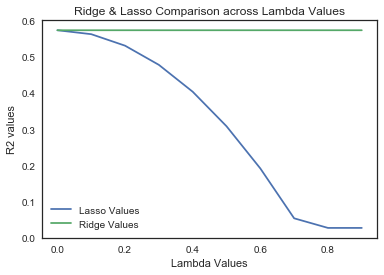

In [43]:
plt.plot(lambda_vals,lasso_r2_vals)
plt.plot(lambda_vals,ridge_r2_vals)
plt.legend(['Lasso Values','Ridge Values'],loc='lower left')
plt.title('Ridge & Lasso Comparison across Lambda Values')
plt.xlabel('Lambda Values')
plt.ylabel('R2 values')
plt.show()